In [ ]:
!pip install -U scikit-learn==1.4.2 imbalanced-learn==0.12.0 --quiet

In [1]:
# TabTransformer Implementation for IEEE-CIS Dataset
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

#from torch.amp import autocast, GradScaler
from torch.cuda.amp import  autocast, GradScaler 
#from torch.amp import autocast
import gc

from sklearn.model_selection import train_test_split

import shap

from imblearn.over_sampling import SMOTE, BorderlineSMOTE

In [2]:
import optuna
from sklearn.metrics import roc_auc_score
from torch.optim import Adam, AdamW
import torch.nn as nn

In [3]:
def evaluation_metrics(y_test, y_pred):
# 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", cm)

# Create display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])

# Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix Visualization')
    plt.show()

# 2. Classification Report
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:\n", report)

# 3. Precision, Recall, F1-Score
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# 4. ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print(f"AUC-ROC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# 5. Precision-Recall Curve and Average Precision
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred)
    avg_precision = average_precision_score(y_test, y_pred)
    print(f"Average Precision (PR AUC): {avg_precision:.4f}")

    plt.figure(figsize=(6, 4))
    plt.plot(recall_vals, precision_vals, label=f'Avg Precision = {avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, y, cat_cols):
        self.X_cats = torch.tensor(X[cat_cols].values, dtype=torch.long)
        self.X_nums = torch.tensor(X.drop(columns=cat_cols).values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_cats[idx], self.X_nums[idx], self.y[idx]

In [6]:
class SHAPWrapper:
    def __init__(self, model, cat_cols, num_cols):
        self.model = model
        self.cat_cols = cat_cols
        self.num_cols = num_cols

    def __call__(self, X_input):
        self.model.eval()
        X_input = torch.tensor(X_input, dtype=torch.float32).to(device)
        x_cat = X_input[:, :len(self.cat_cols)].long()
        x_num = X_input[:, len(self.cat_cols):]
        with torch.no_grad():
            logits = self.model(x_cat, x_num)
            probs = torch.sigmoid(logits)
        return probs.cpu().numpy()

In [7]:
def readfile(path, file):
    file_path = os.path.join(path, file)
    df = pd.read_csv(file_path)
    return df
    
def reduce_mem_usage(df):
    important_cols = ['TransactionAmt']
    for col in df.columns:
        col_type = df[col].dtype
        if col_type in ['int64', 'int32']:
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type in ['float64', 'float32']:
            if col in important_cols:
                df[col] = pd.to_numeric(df[col], downcast='float32')
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
    return df



In [8]:
# -----------------------------
# TabTransformer Model
# -----------------------------

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        return self.norm2(x + ff_out)
'''
    def forward(self, x, return_attention=False):
        attn_out, attn_weights = self.attn(x, x, x, need_weights=return_attention)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x_out = self.norm2(x + ff_out)
        return (x_out, attn_weights) if return_attention else x_out
'''
    





class TabTransformer(nn.Module):
    def __init__(self, categories, num_numerical, embed_dim=32, num_blocks=2, heads=4):
        super().__init__()
        self.embed_layers = nn.ModuleList([
            nn.Embedding(cat_size, embed_dim) for cat_size in categories
        ])
        self.transformer = nn.Sequential(*[TransformerBlock(embed_dim, heads) for _ in range(num_blocks)])
        self.norm = nn.LayerNorm(embed_dim * len(categories))
        self.numerical_proj = nn.Linear(num_numerical, embed_dim * len(categories))
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * len(categories) * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x_cat, x_num):
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embed_layers)]
        x = torch.stack(embedded, dim=1)
        x = self.transformer(x)
        x = x.flatten(1)
        x = self.norm(x)
        x_num_proj = self.numerical_proj(x_num)
        x_comb = torch.cat([x, x_num_proj], dim=1)
        return self.fc(x_comb).squeeze()
        '''

    def forward(self, x_categorical, x_numerical, return_attention=False):
        embedded = [emb(x_categorical[:, i]) for i, emb in enumerate(self.embed_layers)]
        x_cat = torch.stack(embedded, dim=1)  # Shape: (batch, num_cat, embed_dim)

        attn_outs = []
        for layer in self.transformer:
            if return_attention:
                x_cat, attn = layer(x_cat, return_attention=True)
                attn_outs.append(attn.detach().cpu())  # Store attention from each layer
            else:
                x_cat = layer(x_cat)

        x_cat_flat = self.norm(x_cat.flatten(1))
        x_num_proj = self.numerical_proj(x_numerical)
        x = torch.cat([x_cat_flat, x_num_proj], dim=1)
        output = self.fc(x)

        return (output, attn_outs) if return_attention else output
'''

In [10]:
# -----------------------------
# SHAP Integration (Safe)
# -----------------------------
class SHAPWrapper:
    def __init__(self, model, cat_cols, num_cols):
        self.model = model
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.device = next(model.parameters()).device

    def __call__(self, X_input):
        self.model.eval()
        X_tensor = torch.tensor(X_input, dtype=torch.float32, device=self.device)
        x_cat = X_tensor[:, :len(self.cat_cols)].long()
        for i, col in enumerate(self.cat_cols):
            vocab_size = cat_maps[col]
            max_val = x_cat[:, i].max().item()
            if max_val >= vocab_size:
                print(f"[SHAP DEBUG] Column {col} has max value {max_val}, but embedding size is {vocab_size}")
            x_cat[:, i] = torch.clamp(x_cat[:, i], max=vocab_size - 1)
        x_num = X_tensor[:, len(self.cat_cols):]
        with torch.no_grad():
            logits = self.model(x_cat, x_num)
            probs = torch.sigmoid(logits)
        return probs.detach().cpu().numpy().reshape(-1)


In [11]:
def get_top_n_shap_features(shap_values, feature_names, top_n=200):
    
    # Calculate mean absolute SHAP value for each feature
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    
    # Create a DataFrame for sorting and reference
    shap_summary_df = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    }).sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)
    
    # Select top N features
    top_feature_names = shap_summary_df['feature'].head(top_n).tolist()
    
    return top_feature_names, shap_summary_df

In [12]:

path = r'/kaggle/input/thesis-dataset' 


identity_file_name = 'train_identity.csv'
transaction_file_name = 'train_transaction.csv'

df_identity = readfile(path, identity_file_name)
print(df_identity.shape)

df_trans = readfile(path, transaction_file_name)
print(df_trans.shape)

df = pd.merge(df_trans, df_identity,how = "left", on = ['TransactionID'])

print(df.shape)

#print(df.columns)

del df_trans, df_identity
gc.collect()

(144233, 41)
(590540, 394)
(590540, 434)


7

In [13]:

# -----------------------------
# Feature Engineering
# -----------------------------
y = df['isFraud']
X = df.drop(['isFraud', 'TransactionID'], axis=1)

# Identify categorical and numerical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype != 'object']
X[categorical_cols] = X[categorical_cols].astype(str).fillna('missing')

# Label encode categoricals
cat_maps = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    cat_maps[col] = len(le.classes_)

ordered_columns = categorical_cols + numerical_cols
X = X[ordered_columns]

# Safety check
for col in categorical_cols:
    max_val = X[col].max()
    if max_val >= cat_maps[col]:
        print(f"[ERROR] Column {col} has value {max_val} but embedding size is {cat_maps[col]}")


# Handle numerical columns
X = X.fillna(-999)
numerical_cols = [col for col in X.columns if col not in categorical_cols]
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#train_ds = TabularDataset(X_train, y_train, categorical_cols)
#val_ds = TabularDataset(X_val, y_val, categorical_cols)

#train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
#val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

In [14]:
       
# -----------------------------
# Training
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_ds = TabularDataset(X_train, y_train, categorical_cols)
val_ds = TabularDataset(X_val, y_val, categorical_cols)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

model = TabTransformer(categories=[cat_maps[col] for col in categorical_cols],
                       num_numerical=len(numerical_cols)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([len(y_train[y_train==0]) / len(y_train[y_train==1])]).to(device)
)
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

best_auc = 0
patience, wait = 5, 0

for epoch in range(10):
    model.train()
    for x_cat, x_num, yb in train_loader:
        x_cat, x_num, yb = x_cat.to(device), x_num.to(device), yb.to(device)
        yb = yb.float().view(-1)
        optimizer.zero_grad()
        with autocast():
            preds = model(x_cat, x_num).view(-1)
            loss = loss_fn(preds, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

    model.eval()

   # with torch.no_grad():
      #  (logits, attn_weights) = model(x_cat, x_num, return_attention=True)

# Visualize attention of the last transformer block
   # import seaborn as sns
   # import matplotlib.pyplot as plt

   # attn = attn_weights[-1][0]  # Get first sample's attention, shape: (n_heads, num_cat, num_cat)
   # head = 0  # You can choose which head to visualize
   # print("Attention shape:", attn.shape)        # (n_heads, seq_len, seq_len)
   # print("Head shape:", attn[head].shape)       # Should be (seq_len, seq_len)
   # print("Labels length:", len(categorical_cols))
   # plt.figure(figsize=(8, 6))
   # sns.heatmap(attn, cmap='viridis', xticklabels=categorical_cols, yticklabels=categorical_cols)
   # plt.title(f"Attention Head {head} of Last Transformer Block")
   # plt.xlabel("Key Features")
   # plt.ylabel("Query Features")
    #plt.show()

    preds_all, y_all = [], []
    with torch.no_grad():
        for x_cat, x_num, yb in val_loader:
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            with autocast():
                logits = model(x_cat, x_num)
                probs = torch.sigmoid(logits)
            preds_all.extend(probs.cpu().numpy())
            y_all.extend(yb.numpy())

    auc = roc_auc_score(y_all, preds_all)
    scheduler.step(auc)
    pred_binary = (np.array(preds_all) > 0.5).astype(int)
    precision = precision_score(y_all, pred_binary)
    recall = recall_score(y_all, pred_binary)
    f1 = f1_score(y_all, pred_binary)

    print(f"Epoch {epoch+1}: AUC = {auc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

    if auc > best_auc:
        best_auc = auc
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 1: AUC = 0.8564, Precision = 0.1441, Recall = 0.7046, F1 = 0.2392


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 2: AUC = 0.8701, Precision = 0.1719, Recall = 0.7060, F1 = 0.2765


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 3: AUC = 0.8810, Precision = 0.1248, Recall = 0.8033, F1 = 0.2160


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 4: AUC = 0.8836, Precision = 0.1428, Recall = 0.7791, F1 = 0.2413


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 5: AUC = 0.8668, Precision = 0.1465, Recall = 0.7331, F1 = 0.2442


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 6: AUC = 0.8901, Precision = 0.1567, Recall = 0.7733, F1 = 0.2605


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 7: AUC = 0.8930, Precision = 0.1736, Recall = 0.7653, F1 = 0.2830


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 8: AUC = 0.8960, Precision = 0.1679, Recall = 0.7781, F1 = 0.2763


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 9: AUC = 0.8933, Precision = 0.2158, Recall = 0.7145, F1 = 0.3315


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 10: AUC = 0.8937, Precision = 0.1525, Recall = 0.7905, F1 = 0.2557


In [15]:
# Set model to evaluation mode
model.eval()

# Storage for predictions and labels
preds_all, y_all = [], []

# Disable gradient computation for evaluation
with torch.no_grad():
    for x_cat, x_num, yb in val_loader:
        x_cat, x_num = x_cat.to(device), x_num.to(device)
        
        # Get model output
        with autocast():
            logits = model(x_cat, x_num)
            probs = torch.sigmoid(logits)
        
        # Store predictions and true labels
        preds_all.extend(probs.cpu().numpy().flatten())  # Flatten to make it 1D
        y_all.extend(yb.numpy().flatten())

# Convert predictions to binary using threshold 0.5
pred_binary = (np.array(preds_all) > 0.5).astype(int)

# Calculate evaluation metrics
auc = roc_auc_score(y_all, preds_all)
precision = precision_score(y_all, pred_binary)
recall = recall_score(y_all, pred_binary)
f1 = f1_score(y_all, pred_binary)

# Print final evaluation
print(f"\nFinal Validation Evaluation:")
print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



Final Validation Evaluation:
AUC-ROC: 0.8937
Precision: 0.1525
Recall: 0.7905
F1-Score: 0.2557


In [ ]:
#evaluation_metrics

In [ ]:
def objective(trial):
    # Suggest hyperparameters
    embed_dim = trial.suggest_categorical("embed_dim", [32, 64])
    #num_blocks = trial.suggest_int("num_blocks", 1, 4)
    heads = trial.suggest_categorical("heads", [4, 8])
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 1e-3)
    #dropout = trial.suggest_float("dropout", 0.3,)

    # Model
    model = TabTransformer(
        categories=[cat_maps[col] for col in categorical_cols],
        num_numerical=len(numerical_cols),
        embed_dim=embed_dim,
        num_blocks=2,
        heads=heads,
       # dropout = 0.3
    )

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Loss with class imbalance handling
    pos_weight = torch.tensor([len(y_train[y_train == 0]) / len(y_train[y_train == 1])])
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

    best_auc = 0
    patience, wait = 5, 0

    for epoch in range(10):
        model.train()
        for x_cat, x_num, yb in train_loader:
            x_cat, x_num, yb = x_cat, x_num, yb
            yb = yb.float().unsqueeze(1)  # ✅ fix: ensure correct shape and type

            optimizer.zero_grad()
            #with autocast(device_type='cuda'):
            with autocast():
                preds = model(x_cat, x_num).view(-1)     # ✅ Flatten output
                loss = loss_fn(preds, yb.float().view(-1))
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

        # Evaluation
        model.eval()
        all_preds, all_targets = [], []
        with torch.no_grad():
            for x_cat, x_num, yb in val_loader:
                x_cat, x_num, yb = x_cat, x_num, yb
                yb = yb.float().view(-1)  # ✅ fix: ensure consistency
                logits = model(x_cat, x_num)
                if logits.dim() == 2 and logits.size(1) == 1:
                    logits = logits.squeeze(1)
                probs = torch.sigmoid(logits).cpu().numpy()
                all_preds.extend(probs)
                all_targets.extend(yb.cpu().numpy())

        auc = roc_auc_score(all_targets, all_preds)
        scheduler.step(auc)

        if auc > best_auc:
            best_auc = auc
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    return best_auc


In [ ]:

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best AUC:", study.best_value)
print("Best hyperparameters:", study.best_params)

best_params = study.best_params

  0%|          | 0/10 [00:00<?, ?it/s]

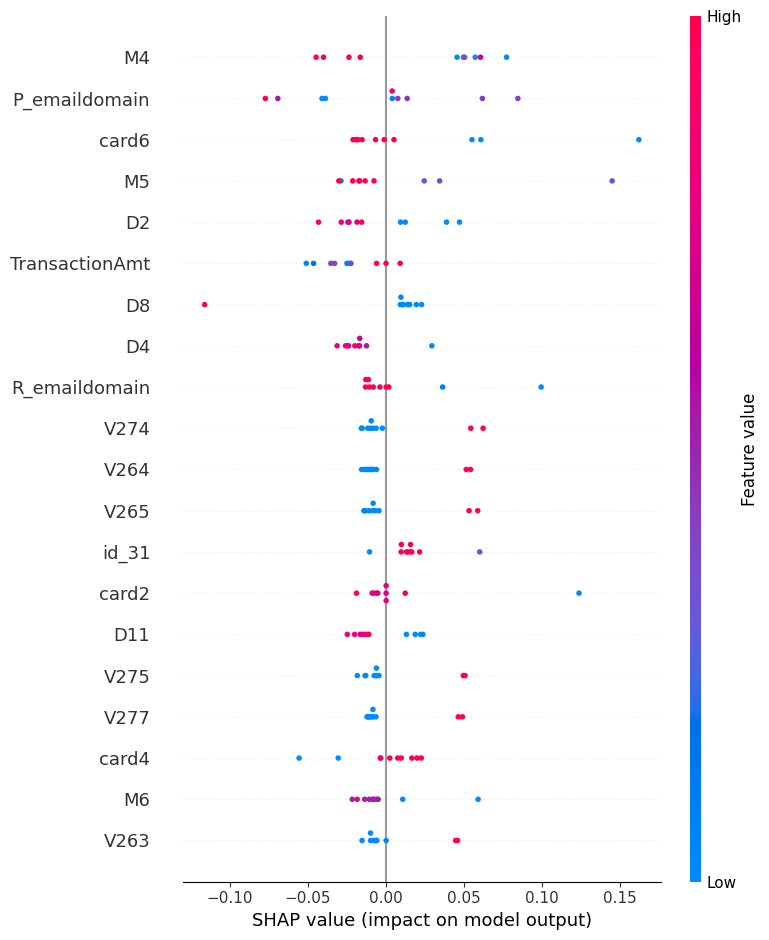

In [16]:

sample_df = X_val.copy().reset_index(drop=True)
sample_df = sample_df[ordered_columns]
background = sample_df.sample(100, random_state=42).astype(np.float32).values
to_explain = sample_df.iloc[:10].astype(np.float32).values

wrapped_model = SHAPWrapper(model, categorical_cols, numerical_cols)
explainer = shap.KernelExplainer(wrapped_model, background)
shap_values = explainer.shap_values(to_explain)

shap.summary_plot(shap_values, to_explain, feature_names=ordered_columns)

In [17]:


# -----------------------------
# Example Usage
# -----------------------------
# shap_values: (n_samples, n_features) – from SHAP explainer
# feature_names: List of column names (ordered to match shap_values)

top_100_features, shap_df = get_top_n_shap_features(shap_values, ordered_columns, top_n=200)

# Print or save:
print(top_100_features)
#shap_df.to_csv("shap_feature_ranking.csv", index=False)

['M4', 'P_emaildomain', 'card6', 'M5', 'D2', 'TransactionAmt', 'D8', 'D4', 'R_emaildomain', 'V274', 'V264', 'V265', 'id_31', 'card2', 'D11', 'V275', 'V277', 'card4', 'M6', 'V263', 'M3', 'D13', 'TransactionDT', 'id_14', 'D6', 'D1', 'V273', 'D3', 'id_10', 'D9', 'D12', 'id_15', 'id_01', 'V278', 'id_09', 'V216', 'card3', 'D7', 'id_30', 'DeviceInfo', 'V215', 'ProductCD', 'V285', 'D5', 'V130', 'id_02', 'addr1', 'V214', 'M7', 'V303', 'V207', 'M8', 'M2', 'V304', 'M1', 'addr2', 'card1', 'V314', 'V276', 'V310', 'id_33', 'V166', 'V266', 'V249', 'D15', 'id_29', 'id_13', 'D14', 'V205', 'V202', 'V252', 'dist1', 'V240', 'DeviceType', 'V302', 'V312', 'id_20', 'V228', 'V224', 'V237', 'V261', 'V243', 'V272', 'V226', 'V268', 'V242', 'V309', 'M9', 'V248', 'V235', 'V206', 'V247', 'id_37', 'V219', 'V241', 'V230', 'V267', 'V262', 'V233', 'V271', 'V287', 'id_16', 'V225', 'V244', 'V290', 'V269', 'V201', 'V284', 'id_36', 'id_28', 'V223', 'V236', 'V258', 'V162', 'id_35', 'V254', 'V313', 'id_05', 'V260', 'V232', 

In [ ]:
len(top_100_features)

In [18]:
top_100_features = ['card6', 'M4', 'D2', 'D8', 'TransactionAmt', 'D6', 'M5', 'P_emaildomain', 'D4', 'D13', 'V264', 'V265', 'V275', 'M6', 'V274', 'card4', 'M3', 'D1', 'R_emaildomain', 'D11', 'card2', 'TransactionDT', 'V263', 'ProductCD', 'V277', 'D3', 'V273', 'D9', 'id_01', 'id_10', 'id_02', 'id_09', 'M7', 'V310', 'V130', 'V285', 'V278', 'V207', 'id_14', 'addr1', 'DeviceInfo', 'V303', 'V216', 'card3', 'id_13', 'V215', 'D7', 'M8', 'V214', 'V276', 'V266', 'V304', 'dist1', 'id_31', 'V166', 'id_35', 'V269', 'M2', 'V271', 'id_15', 'V240', 'V262', 'card1', 'D12', 'D15', 'V247', 'id_30', 'V241', 'V260', 'V249', 'V225', 'id_29', 'V228', 'V205', 'V243', 'V309', 'V224', 'V248', 'V236', 'V257', 'V223', 'V252', 'V302', 'V244', 'M9', 'DeviceType', 'V226', 'V235', 'id_06', 'V254', 'V313', 'M1', 'id_32', 'id_19', 'V230', 'V217', 'V261', 'V202', 'V237', 'V253']

In [19]:

# -----------------------------
# Feature Engineering
# -----------------------------
y_100 = df['isFraud']
X_100 = df[top_100_features]

# Identify categorical and numerical columns
categorical_cols = [col for col in X_100.columns if X_100[col].dtype == 'object']
numerical_cols = [col for col in X_100.columns if X_100[col].dtype != 'object']
X_100[categorical_cols] = X_100[categorical_cols].astype(str).fillna('missing')

# Label encode categoricals
cat_maps = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_100[col] = le.fit_transform(X_100[col].astype(str))
    cat_maps[col] = len(le.classes_)

ordered_columns = categorical_cols + numerical_cols
X_100 = X_100[ordered_columns]

# Safety check
for col in categorical_cols:
    max_val = X_100[col].max()
    if max_val >= cat_maps[col]:
        print(f"[ERROR] Column {col} has value {max_val} but embedding size is {cat_maps[col]}")


# Handle numerical columns
X_100 = X_100.fillna(-999)
numerical_cols = [col for col in X_100.columns if col not in categorical_cols]
scaler = StandardScaler()
X_100[numerical_cols] = scaler.fit_transform(X_100[numerical_cols])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [20]:
# -----------------------------
# Training
# -----------------------------
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_val, y_train, y_val = train_test_split(X_100, y_100, test_size=0.2, stratify=y, random_state=42)

train_ds = TabularDataset(X_train, y_train, categorical_cols)
val_ds = TabularDataset(X_val, y_val, categorical_cols)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

model = TabTransformer(categories=[cat_maps[col] for col in categorical_cols],
                       num_numerical=len(numerical_cols)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([len(y_train[y_train==0]) / len(y_train[y_train==1])]).to(device)
)
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

best_auc = 0
patience, wait = 5, 0

for epoch in range(10):
    model.train()
    for x_cat, x_num, yb in train_loader:
        x_cat, x_num, yb = x_cat.to(device), x_num.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast():
            preds = model(x_cat, x_num)
            loss = loss_fn(preds, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

    model.eval()

    
    preds_all, y_all = [], []
    with torch.no_grad():
        for x_cat, x_num, yb in val_loader:
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            with autocast():
                logits = model(x_cat, x_num)
                probs = torch.sigmoid(logits)
            preds_all.extend(probs.cpu().numpy())
            y_all.extend(yb.numpy())

    auc = roc_auc_score(y_all, preds_all)
    scheduler.step(auc)
    pred_binary = (np.array(preds_all) > 0.5).astype(int)
    precision = precision_score(y_all, pred_binary)
    recall = recall_score(y_all, pred_binary)
    f1 = f1_score(y_all, pred_binary)

    print(f"Epoch {epoch+1}: AUC = {auc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

    if auc > best_auc:
        best_auc = auc
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 1: AUC = 0.8333, Precision = 0.1350, Recall = 0.6613, F1 = 0.2242


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 2: AUC = 0.8721, Precision = 0.1276, Recall = 0.7726, F1 = 0.2191


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 3: AUC = 0.8824, Precision = 0.1193, Recall = 0.8043, F1 = 0.2078


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 4: AUC = 0.8826, Precision = 0.1439, Recall = 0.7665, F1 = 0.2424


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 5: AUC = 0.8896, Precision = 0.1492, Recall = 0.7743, F1 = 0.2502


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 6: AUC = 0.8925, Precision = 0.1631, Recall = 0.7597, F1 = 0.2685


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 7: AUC = 0.8938, Precision = 0.1403, Recall = 0.8064, F1 = 0.2390


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 8: AUC = 0.8951, Precision = 0.1547, Recall = 0.7895, F1 = 0.2587


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 9: AUC = 0.9004, Precision = 0.1776, Recall = 0.7687, F1 = 0.2885


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch 10: AUC = 0.8999, Precision = 0.2013, Recall = 0.7479, F1 = 0.3173


In [21]:
torch.save(model.state_dict(), 'tabtransformer_GAN.pth')

In [ ]:
def plot_precision_recall_roc(y_true, y_probs):
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot both
    plt.figure(figsize=(12, 5))

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}', color='purple')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}', color='darkorange')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# If you're using model.predict_proba
#y_probs = model.predict_proba(X_test)[:, 1]  # or use torch.sigmoid(logits)
#y_true = y_test  # or actual labels

from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

plot_precision_recall_roc(y_all, pred_binary)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example adjustable function for SMOTE with different fraud percentages
def apply_smote_with_ratio(X, y, fraud_percentage):
    smote = SMOTE(sampling_strategy=fraud_percentage / 100.0, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# Example: apply 20%, 40%, 60%, 80% fraud oversampling
fraud_percentages = [20, 40, 60, 80]
for percent in fraud_percentages:
    print(f"\nApplying SMOTE with fraud percentage: {percent}%")
    X_train, X_val, y_train, y_val = train_test_split(X_100, y_100, test_size=0.2, stratify=y_100, random_state=42)
    # Apply SMOTE
    X_smote, y_smote = apply_smote_with_ratio(X, y, percent)

    # Train-Validation Split
    #X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=42)

    # Prepare TabularDataset as per your implementation
    train_ds = TabularDataset(X_train, y_train, categorical_cols)
    val_ds = TabularDataset(X_val, y_val, categorical_cols)

    # DataLoaders
    train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

    # Initialize Model
    model = TabTransformer(
        categories=[cat_maps[col] for col in categorical_cols],
        num_numerical=len(numerical_cols)
    ).to(device)

    # Print dataset size after SMOTE
    print(f"Training samples: {len(train_ds)} | Validation samples: {len(val_ds)}")

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([len(y_train[y_train==0]) / len(y_train[y_train==1])]).to(device)
    )
    scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

    best_auc = 0
    patience, wait = 5, 0

    for epoch in range(10):
        model.train()
        for x_cat, x_num, yb in train_loader:
            x_cat, x_num, yb = x_cat.to(device), x_num.to(device), yb.to(device)
            optimizer.zero_grad()
            with autocast():
                preds = model(x_cat, x_num)
                loss = loss_fn(preds, yb)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

    model.eval()
    preds_all, y_all = [], []
    with torch.no_grad():
        for x_cat, x_num, yb in val_loader:
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            with autocast():
                logits = model(x_cat, x_num)
                probs = torch.sigmoid(logits)
            preds_all.extend(probs.cpu().numpy())
            y_all.extend(yb.numpy())

        auc = roc_auc_score(y_all, preds_all)
        scheduler.step(auc)
        pred_binary = (np.array(preds_all) > 0.5).astype(int)
        precision = precision_score(y_all, pred_binary)
        recall = recall_score(y_all, pred_binary)
        f1 = f1_score(y_all, pred_binary)

        print(f"Epoch {epoch+1}: AUC = {auc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

        if auc > best_auc:
            best_auc = auc
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break


In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

plot_precision_recall_roc(y_all, pred_binary)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Assume:
# - df_real_fraud: Real fraud samples (DataFrame)
# - synthetic_fraud: Synthetic fraud samples (DataFrame)

def apply_smote_with_ratio(X, y, fraud_percentage):
    #smote = SMOTE(sampling_strategy=fraud_percentage / 100.0, random_state=42)
    smote = BorderlineSMOTE(sampling_strategy=.2, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled


fraud_percentages = [40]
for percent in fraud_percentages:
    print(f"\nApplying SMOTE with fraud percentage: {percent}%")
    X_train, X_val, y_train, y_val = train_test_split(X_100, y_100, test_size=0.2, stratify=y_100, random_state=42)
    # Apply SMOTE
    X_smote, y_smote = apply_smote_with_ratio(X, y, percent)

df_fraud = X_100.copy()
synthetic_fraud = X_smote.copy()

# Drop 'isFraud' if present
if 'isFraud' in df_fraud.columns:
    df_fraud = df_fraud.drop(columns=['isFraud'])

if 'isFraud' in synthetic_fraud.columns:
    synthetic_fraud = synthetic_fraud.drop(columns=['isFraud'])

# Sample if too large (for faster t-SNE)
real_sample = df_fraud.sample(n=1000, random_state=42).select_dtypes(include=['int64', 'float64'])
synthetic_sample = synthetic_fraud.sample(n=1000, random_state=42).select_dtypes(include=['int64', 'float64'])

# Combine for visualization
combined = pd.concat([real_sample, synthetic_sample], axis=0)
combined.fillna(0,inplace = True)
labels = ['Real'] * len(real_sample) + ['Synthetic'] * len(synthetic_sample)

# Run t-SNE
print("🔵 Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined)
tsne_results = tsne.fit_transform(combined_scaled)

# Plot
plt.figure(figsize=(10,7))
plt.scatter(tsne_results[:len(real_sample), 0], tsne_results[:len(real_sample), 1], label="Real Fraud", alpha=0.6,c='blue')
plt.scatter(tsne_results[len(synthetic_sample):, 0], tsne_results[len(synthetic_sample):, 1], label="Synthetic Fraud", alpha=0.6,c='orange')
plt.title("t-SNE Visualization: Real vs Synthetic Fraud Samples")
plt.legend()
plt.show()

# Umap - 

In [ ]:
#!pip install -q sdv
#!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install -q ctgan

In [ ]:
from ctgan import CTGAN

ctgan = CTGAN()
print("CTGAN loaded successfully!")

In [ ]:
imb_features = ['isFraud', 'card6', 'M4', 'D2', 'D8', 'TransactionAmt', 'D6', 'M5', 'P_emaildomain', 'D4', 'D13', 'V264', 'V265', 'V275', 'M6', 'V274', 'card4', 'M3', 'D1', 'R_emaildomain', 'D11', 'card2', 'TransactionDT', 'V263', 'ProductCD', 'V277', 'D3', 'V273', 'D9', 'id_01', 'id_10', 'id_02', 'id_09', 'M7', 'V310', 'V130', 'V285', 'V278', 'V207', 'id_14', 'addr1', 'DeviceInfo', 'V303', 'V216', 'card3', 'id_13', 'V215', 'D7', 'M8', 'V214', 'V276', 'V266', 'V304', 'dist1', 'id_31', 'V166', 'id_35', 'V269', 'M2', 'V271', 'id_15', 'V240', 'V262', 'card1', 'D12', 'D15', 'V247', 'id_30', 'V241', 'V260', 'V249', 'V225', 'id_29', 'V228', 'V205', 'V243', 'V309', 'V224', 'V248', 'V236', 'V257', 'V223', 'V252', 'V302', 'V244', 'M9', 'DeviceType', 'V226', 'V235', 'id_06', 'V254', 'V313', 'M1', 'id_32', 'id_19', 'V230', 'V217', 'V261', 'V202', 'V237', 'V253']

In [ ]:
df_imb = df[imb_features].copy()
#df_imb = df.copy()
df_imb.shape

y_100 = df_imb['isFraud']
X_100 = df_imb.drop(['isFraud'], axis=1)

# Identify categorical and numerical columns
categorical_cols = [col for col in X_100.columns if X_100[col].dtype == 'object']
numerical_cols = [col for col in X_100.columns if X_100[col].dtype != 'object']
X_100[categorical_cols] = X_100[categorical_cols].astype(str).fillna('NA')

# Label encode categoricals
cat_maps = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_100[col] = le.fit_transform(X_100[col].astype(str))
    cat_maps[col] = len(le.classes_)

ordered_columns = categorical_cols + numerical_cols
X_100 = X_100[ordered_columns]

# Safety check
for col in categorical_cols:
    max_val = X_100[col].max()
    if max_val >= cat_maps[col]:
        print(f"[ERROR] Column {col} has value {max_val} but embedding size is {cat_maps[col]}")


# Handle numerical columns
X_100 = X_100.fillna(-999)
numerical_cols = [col for col in X_100.columns if col not in categorical_cols]
scaler = StandardScaler()
X_100[numerical_cols] = scaler.fit_transform(X_100[numerical_cols])

X_train, X_val, y_train, y_val = train_test_split(X_100, y_100, test_size=0.3, stratify=y_100, random_state=42)

In [ ]:
df_fraud = X_train[y_train == 1]
df_nonfraud = X_train[y_train == 0]

print(f"Fraud: {len(df_fraud)}, Non-Fraud: {len(df_nonfraud)}")

In [ ]:
df_fraud.fillna(0, inplace=True)

#df_fraud.drop(columns='isFraud',inplace = True)
categorical_columns = df_fraud.select_dtypes(include='object').columns.tolist()
numerical_columns = df_fraud.select_dtypes(exclude='object').columns.tolist()

for col in categorical_columns:
   df_fraud[col] = df_fraud[col].astype(str)

#df_fraud = df_fraud.copy()

df_fraud_sampled = df_fraud.sample(2000) 

# Train CTGAN
ctgan = CTGAN(epochs=20)
print(f"Training CTGAN on {df_fraud_sampled.shape[0]} rows with {len(categorical_columns)} categorical features...")
ctgan.fit(df_fraud_sampled, discrete_columns=categorical_columns)



In [ ]:

# Sample synthetic frauds
synthetic_fraud = ctgan.sample(5000)
synthetic_fraud['isFraud'] = 1

print("✅ Synthetic fraud records generated!")

In [ ]:
from sklearn.manifold import TSNE


import matplotlib.pyplot as plt
import pandas as pd

# Assume:
# - df_real_fraud: Real fraud samples (DataFrame)
# - synthetic_fraud: Synthetic fraud samples (DataFrame)

# Drop 'isFraud' if present
if 'isFraud' in df_fraud.columns:
    df_fraud = df_fraud.drop(columns=['isFraud'])

if 'isFraud' in synthetic_fraud.columns:
    synthetic_fraud = synthetic_fraud.drop(columns=['isFraud'])

# Sample if too large (for faster t-SNE)
real_sample = df_fraud.sample(n=1000, random_state=42).select_dtypes(include=['int64', 'float64'])
synthetic_sample = synthetic_fraud.sample(n=1000, random_state=42).select_dtypes(include=['int64', 'float64'])

# Combine for visualization
combined = pd.concat([real_sample, synthetic_sample], axis=0)
combined.fillna(0,inplace = True)
labels = ['Real'] * len(real_sample) + ['Synthetic'] * len(synthetic_sample)

# Run t-SNE
print("🔵 Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(combined)

# Plot
plt.figure(figsize=(10,7))
plt.scatter(tsne_results[:len(real_sample), 0], tsne_results[:len(real_sample), 1], label="Real Fraud", alpha=0.6)
plt.scatter(tsne_results[len(real_sample):, 0], tsne_results[len(real_sample):, 1], label="Synthetic Fraud", alpha=0.6)
plt.title("t-SNE Visualization: Real vs Synthetic Fraud Samples")
plt.legend()
plt.show()

# Umap - 

In [ ]:
df_fraud.columns

In [ ]:
from sklearn.utils import shuffle
df_nonfraud[['isFraud']]=0
df_fraud[['isFraud']]=1
synthetic_fraud[['isFraud']]=1

df_augmented = pd.concat([df_nonfraud,df_fraud, synthetic_fraud], ignore_index=True)


df_augmented = shuffle(df_augmented, random_state=42).reset_index(drop=True)

print("Dataset shape after merging:", df_augmented.shape)
print(df_augmented['isFraud'].value_counts())

In [ ]:
X_100.shape

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



train_ds = TabularDataset(X_train, y_train, categorical_cols)
val_ds = TabularDataset(X_val, y_val, categorical_cols)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

model = TabTransformer(categories=[cat_maps[col] for col in categorical_cols],
                       num_numerical=len(numerical_cols)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([len(y_train[y_train==0]) / len(y_train[y_train==1])]).to(device)
)
scaler = GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

best_auc = 0
patience, wait = 5, 0

for epoch in range(10):
    model.train()
    for x_cat, x_num, yb in train_loader:
        x_cat, x_num, yb = x_cat.to(device), x_num.to(device), yb.to(device)
        optimizer.zero_grad()
        with autocast():
            preds = model(x_cat, x_num)
            loss = loss_fn(preds, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

    model.eval()

    
    
    preds_all, y_all = [], []
    with torch.no_grad():
        for x_cat, x_num, yb in val_loader:
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            with autocast():
                logits = model(x_cat, x_num)
                probs = torch.sigmoid(logits)
            preds_all.extend(probs.cpu().numpy())
            y_all.extend(yb.numpy())

    auc = roc_auc_score(y_all, preds_all)
    scheduler.step(auc)
    pred_binary = (np.array(preds_all) > 0.5).astype(int)
    precision = precision_score(y_all, pred_binary)
    recall = recall_score(y_all, pred_binary)
    f1 = f1_score(y_all, pred_binary)

    print(f"Epoch {epoch+1}: AUC = {auc:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

    if auc > best_auc:
        best_auc = auc
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

In [ ]:
torch.save(model.state_dict(), 'tabtransformer_GAN.pth')

In [ ]:
sample_df = X_val.copy().reset_index(drop=True)
sample_df = sample_df[ordered_columns]
background = sample_df.sample(100, random_state=42).astype(np.float32).values
to_explain = sample_df.iloc[:10].astype(np.float32).values

wrapped_model = SHAPWrapper(model, categorical_cols, numerical_cols)
explainer = shap.KernelExplainer(wrapped_model, background)
shap_values = explainer.shap_values(to_explain)

#explainer = shap.Explainer(wrapped_model, background)
#explanation = explainer(to_explain)

#shap.plots.beeswarm(explanation)

shap.summary_plot(shap_values, to_explain, feature_names=ordered_columns)


In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

plot_precision_recall_roc(y_all, pred_binary)

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# -----------------------------
# CONFIGURATION
# -----------------------------
model_id = "google/flan-t5-large"  # Or use another instruct model
#device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
)
model.to(device)
model.eval()

# -----------------------------
# SHAP TO NATURAL LANGUAGE PROMPT
# -----------------------------
def generate_shap_llm_prompt(shap_values, feature_values, feature_names, top_n=5):
    feature_contributions = [
        (feature_names[i], shap_values[i], feature_values[i])
        for i in range(len(feature_names))
    ]
    # Filter only those that increased the fraud risk
    sorted_features = sorted(
        [f for f in feature_contributions if f[1] > 0],
        key=lambda x: x[1],
        reverse=True
    )[:top_n]

    if not sorted_features:
        return "No features increased the fraud score significantly."

    explanation_lines = [
        f"- Feature: **{name}**, Value: {val}, Contribution: +{shap_val:.4f}"
        for name, shap_val, val in sorted_features
    ]

    explanation_text = "\n".join(explanation_lines)

    prompt = f"""
You are a fraud detection assistant.

A machine learning model has predicted that the following transaction is **fraudulent**.

Below are the top features that increased the fraud score, along with their values and contributions:

{explanation_text}

Write a short explanation for an analyst. Clearly mention **each feature** and how it contributed to the fraud prediction.
Use a bullet point for each feature.
"""
    return prompt.strip()

# -----------------------------
# HUGGING FACE INFERENCE
# -----------------------------
def get_hf_explanation(prompt, max_tokens=128):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=0.7,
            top_k=50,
            top_p=0.9,
            do_sample=True
        )
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response.strip()

# -----------------------------
# USAGE EXAMPLE
# -----------------------------
# Replace with real SHAP output
shap_row = shap_values[0]          # SHAP values for one row
feature_row = to_explain[0]        # Feature values for same row
feature_names = ordered_columns    # Ordered list of feature names

prompt = generate_shap_llm_prompt(shap_row, feature_row, feature_names, top_n=5)
explanation = get_hf_explanation(prompt)

print("📝 Hugging Face Explanation:")
print(explanation)


In [ ]:
explanation